In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

model_path = "./data/model_data/models"
feature_path = "./data/model_data/period_features"
save_path = "./result"

def load_feature_names(num_period: int, feature_path: str = feature_path) -> pd.DataFrame:
    data = pd.read_parquet(f"{feature_path}/features_period_{num_period}.parquet")
    return data.columns.difference(["Date", "Ticker", "Return_tomorrow", "Target"])

In [2]:
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
from DNN import MaxoutNetWithRegularization

def load_model(model: str, num_period: int, model_path: str = model_path):
    current_model_path = os.path.join(model_path, model)
    if (model == "gbdt") or (model == "rf"):
        return load(f"{current_model_path}/{model}_period_{num_period}.joblib")
    elif model == "xgboost":
        return xgb.Booster(model_file=f"{current_model_path}/{model}_period_{num_period}.json")
    elif model == "lightgbm":
        return lgb.Booster(model_file=f"{current_model_path}/{model}_period_{num_period}.txt")
    elif model == "nn":
        nn = MaxoutNetWithRegularization()
        nn.load_state_dict(torch.load(f"{current_model_path}/{model}_period_{num_period}.pt"))
        return nn
    else:
        raise ValueError("Model not found")

In [15]:
def plot_feature_importance(pos, feature_importance, feature_names, model_name, current_period=None):
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    if current_period in range(25):
        plt.title(f'{model_name} Features Importance of Period {current_period}')
        current_save_path = os.path.join(save_path, model_name, f"{model_name}_feature_importance_{current_period}.png")
    else:
        plt.title(f'{model_name} Features Importance of All Periods')
        current_save_path = os.path.join(save_path, model_name, f"{model_name}_feature_importance_all.png")
    plt.tight_layout()
    plt.savefig(current_save_path)
    plt.close()


def summary_gbdt_feature_importance(model, feature_names: list, current_period: int):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())
    sorted_idx = np.argsort(feature_importance, )
    pos = np.arange(sorted_idx.shape[0]) + .5

    plot_feature_importance(pos, feature_importance[sorted_idx], [feature_names[i] for i in sorted_idx], "gbdt", current_period)
    
    return dict(zip([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx]))


def summary_rf_feature_importance(model, feature_names: list, current_period: int):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())
    sorted_idx = np.argsort(feature_importance, )
    pos = np.arange(sorted_idx.shape[0]) + .5

    plot_feature_importance(pos, feature_importance[sorted_idx], [feature_names[i] for i in sorted_idx], "rf", current_period)

    return dict(zip([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx]))


def summary_xgboost_feature_importance(model, current_period: int):
    feature_importance = model.get_fscore()
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=False)}
    feature_importance = {k: 100.0 * (v-min(feature_importance.values()))/(max(feature_importance.values()) - min(feature_importance.values())) for k, v in feature_importance.items()}
    pos = np.arange(len(feature_importance)) + .5

    plot_feature_importance(pos, list(feature_importance.values()), list(feature_importance.keys()), "xgboost", current_period)
    return feature_importance


def summary_lightgbm_feature_importance(model, current_period: int):
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100.0 * (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())
    sorted_idx = np.argsort(feature_importance, )
    pos = np.arange(sorted_idx.shape[0]) + .5

    plot_feature_importance(pos, feature_importance[sorted_idx], [model.feature_name()[i] for i in sorted_idx], "lightgbm", current_period)
    return dict(zip([model.feature_name()[i] for i in sorted_idx], feature_importance[sorted_idx]))


def summary_nn_feature_importance(model, feature_names: list, current_period: int):
    wei1 = model.maxout1.linear_layers[0].weight.detach().numpy()
    wei2 = model.maxout1.linear_layers[1].weight.detach().numpy()

    wei1 = np.abs(wei1).sum(axis=1)
    wei2 = np.abs(wei2).sum(axis=1)

    feature_importance = np.mean([wei1, wei2], axis=0)
    feature_importance = 100.0 * (feature_importance - np.min(feature_importance)) / (np.max(feature_importance) - np.min(feature_importance))

    sorted_idx = np.argsort(feature_importance, )
    pos = np.arange(sorted_idx.shape[0]) + .5

    plot_feature_importance(pos, feature_importance[sorted_idx], [feature_names[i] for i in sorted_idx], "nn", current_period)
    return dict(zip([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx]))


def summary_feature_importance(model, model_name: str, num_period: int, feature_names: pd.DataFrame):
    if model_name == "gbdt":
        return summary_gbdt_feature_importance(model, feature_names, num_period)
    elif model_name == "rf":
        return summary_rf_feature_importance(model, feature_names, num_period)
    elif model_name == "xgboost":
        return summary_xgboost_feature_importance(model, num_period)
    elif model_name == "lightgbm":
        return summary_lightgbm_feature_importance(model, num_period)
    elif model_name == "nn":
        return summary_nn_feature_importance(model, feature_names, num_period)
    else:
        raise ValueError("Model not found")

In [16]:
from tqdm import tqdm

models = ["gbdt", "rf", "xgboost", "lightgbm", "nn"]
periods = list(range(25))

for model in models[2:3]:
    summary = {}
    for period in tqdm(periods):
        current_model = load_model(model, period)
        feature_names = load_feature_names(period)
        dic = summary_feature_importance(current_model, model, period, feature_names)
        summary[period] = dic
    
    summary = pd.DataFrame(summary)
    summary["mean"] = summary.mean(axis=1)
    summary = summary.sort_values(by="mean", ascending=True)

    feature_importance = summary["mean"].values
    feature_names = summary.index.values
    pos = np.arange(len(feature_importance)) + .5

    plot_feature_importance(pos, feature_importance, feature_names, model)

    summary.to_csv(f"{save_path}/{model}/{model}_feature_importance.csv")

100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


In [20]:
summary = {}
for model in models:
    fi_path = f"{save_path}/{model}/{model}_feature_importance.csv"
    data = pd.read_csv(fi_path, index_col=0)
    mean_importance = data["mean"].to_dict()
    summary[model] = mean_importance
summary_df = pd.DataFrame(summary)
idx = sorted(summary_df.index.to_list(), key=lambda x: int(x.split("_")[-1]))
summary_df = summary_df.loc[idx]
summary_df = 100.0 * (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())
summary_df.head()

,gbdt,rf,xgboost,lightgbm,nn
rtn_1,100.000000,100.000000,100.000000,100.000000,20.314054
rtn_2,2.903844,0.538167,70.522567,58.869313,22.185474
rtn_3,10.765004,34.765385,53.073154,50.722081,39.882639
rtn_4,14.526421,27.780637,39.631132,55.123529,29.023152
rtn_5,6.065540,16.477039,37.388510,31.541126,76.388942


In [29]:
summary_df.to_csv(f"{save_path}/all_models_feature_importance.csv")

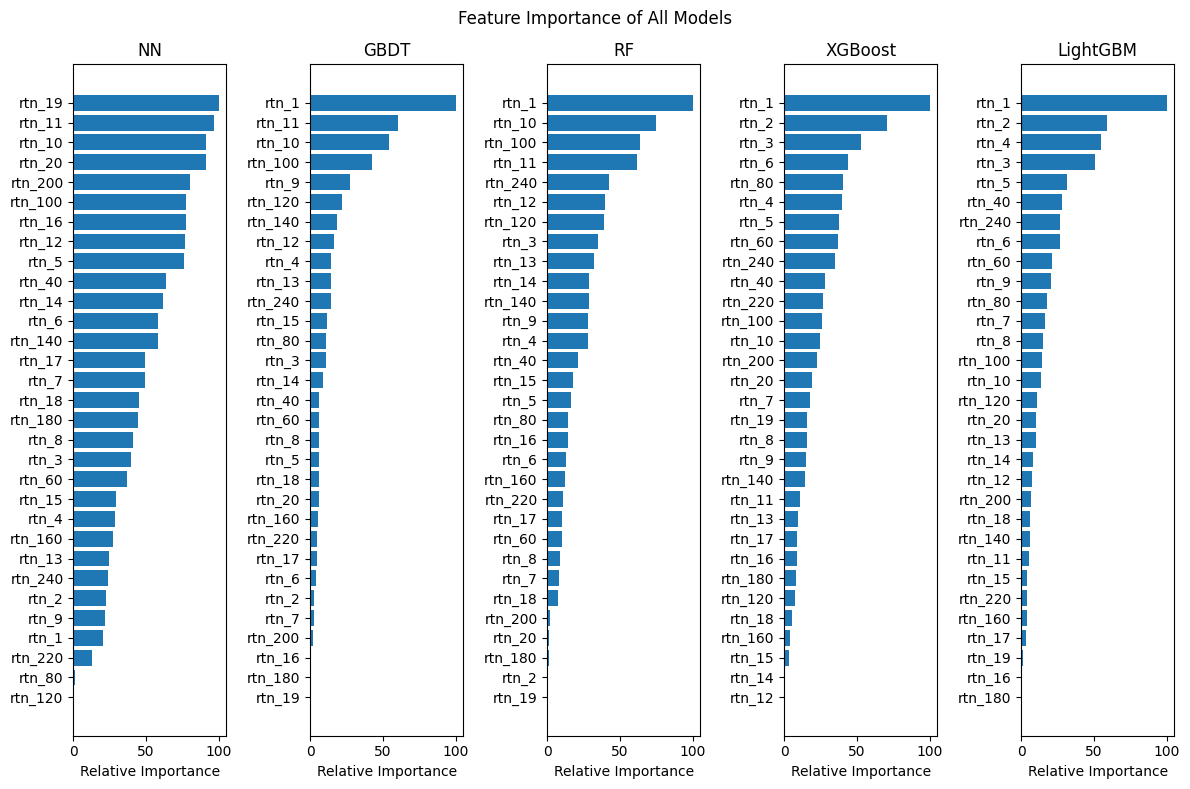

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 5, 1)

fi = summary_df["nn"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('NN')
plt.tight_layout()

plt.subplot(1, 5, 2)

fi = summary_df["gbdt"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('GBDT')
plt.tight_layout()

plt.subplot(1, 5, 3)

fi = summary_df["rf"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('RF')
plt.tight_layout()

plt.subplot(1, 5, 4)

fi = summary_df["xgboost"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('XGBoost')
plt.tight_layout()

plt.subplot(1, 5, 5)

fi = summary_df["lightgbm"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('LightGBM')
plt.tight_layout()

plt.suptitle("Feature Importance of All Models")
plt.tight_layout()

plt.savefig(f"{save_path}/all_models_feature_importance.png")

plt.show()

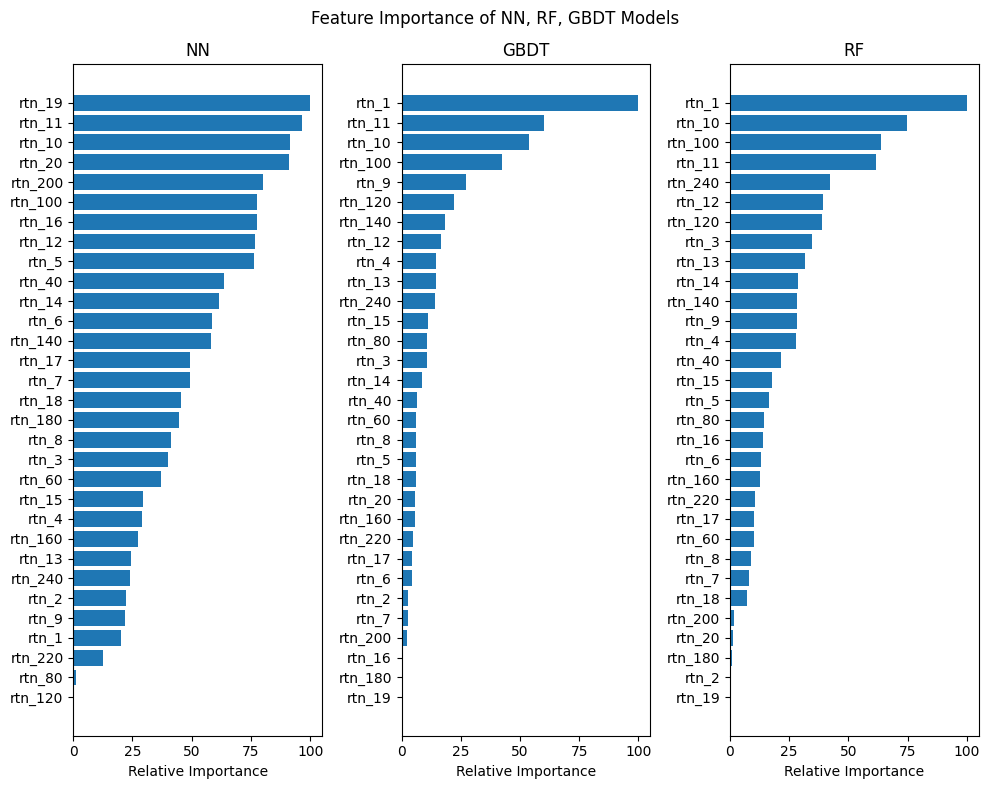

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)

fi = summary_df["nn"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('NN')
plt.tight_layout()

plt.subplot(1, 3, 2)

fi = summary_df["gbdt"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('GBDT')
plt.tight_layout()

plt.subplot(1, 3, 3)

fi = summary_df["rf"].sort_values(ascending=True)
fn = fi.index.to_list()
pos = np.arange(len(fi)) + .5

plt.barh(pos, fi.values, align='center')
plt.yticks(pos, fn)
plt.xlabel('Relative Importance')
plt.title('RF')
plt.tight_layout()

plt.suptitle("Feature Importance of NN, RF, GBDT Models")
plt.tight_layout()

plt.savefig(f"{save_path}/nn_rf_gbdt_feature_importance.png")
plt.show()